# Coherent Point Drift

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

rc('animation', html='html5')

## Coherent Point Drift (CPD)

In [2]:
class CPD:
    '''
        Class implementing the Coherent Point Drift (CPD) method for
        rigid, affine and non-rigid point set registration.
    '''
    def __init__(self, method='rigid'):
        '''
            Initialize CPD class with rigid, affine or non-rigid point set registration.
            
            Parameters
            ----------
            method: str, optional (default: 'rigid')
                    'rigid', 'affine' or 'nonrigid'.
        '''
        self.method = method
        if self.method == 'rigid':
            self.solve = self.solve_rigid
            # Y: np.ndarray of shape = (M, D), R: np.ndarray of shape = (D, D), t: np.ndarray of shape = (D,),
            # s: float
            # Returns np.ndarray of shape = (M, D)
            self.transform = lambda Y, R, t, s: s * Y @ R.T + t
        elif self.method == 'affine':
            self.solve = self.solve_affine
            # Y: np.ndarray of shape = (M, D), B: np.ndarray of shape = (D, D), t: np.ndarray of shape = (D,)
            # Returns np.ndarray of shape = (M, D)
            self.transform = lambda Y, B, t: Y @ B.T + t
        elif self.method == 'nonrigid':
            # Y: np.ndarray of shape = (M, D), G: np.ndarray of shape = (M, M), W: np.ndarray of shape = (M, D)
            # Returns np.ndarray of shape = (M, D)
            self.transform = lambda Y, G, W: Y + G @ W

    def __call__(self, X, Y, w=0.1, beta=2, lmbda=2, max_iterations=100, save_parameters=False):
        '''
            Applies the CPD method to the data in Y to match X.
            
            Parameters
            ----------
            X:                  np.ndarray, shape = (N, D)
                                Set containing N D-dimensional data points.
            Y:                  np.ndarray, shape = (M, D)
                                Set containing M D-dimensional data points.
            w:                  float, optional (default: 0.1)
                                Assumption on the amount of noise in the point sets.
            beta:               float, optional (default: 2)
                                Model of smoothness regularizer (width of Gaussian filter in equation 20).
            lmbda:              float, optional (default: 2)
                                Trade-off between goodness of maximum likelihood fit and regularization.
            max_iterations:     int, optional (default: 2)
                                Maximum number of iterations for the EM optimization.
            save_parameters:    bool, optional (default: False)
                                Whether to save the history of estimated transformation parameters.
            
            Returns
            -------
            Y_aligned:          np.ndarray, shape = (M, D)
                                Aligned Y points.
            P:                  np.ndarray, shape = (M, N)
                                Probabilities for point assignments from Y to X.
        '''
        # Get shapes
        N, D = X.shape
        M = Y.shape[0]
        if self.method == 'rigid':
            # Initialize theta = (R, t, s)
            theta = (np.eye(D), np.zeros(D), 1)
        elif self.method == 'affine':
            # Initialize theta = (B, t)
            theta = (np.eye(D), np.zeros(D))
        elif self.method == 'nonrigid':
            # Initialize W
            W = np.zeros((M, D))
            # Construct G
            G = np.exp(-1 / (2 * beta**2) * cdist(Y, Y, metric='euclidean')**2)
            theta = (G, W)
        if save_parameters:
            self.parameters = [theta]
        # Compute isotropic covariances
        var = 1 / (D * N * M) * np.sum(cdist(X, Y, metric='euclidean')**2)
        # EM optimization
        for iteration in range(max_iterations):
            # E-step: Compute P
            P = np.zeros((M, N))
            for n in range(N):
                P[:, n] = np.exp(-1 / (2 * var) * np.sum((X[n] - self.transform(Y, *theta))**2, axis=1))
            P /= np.sum(P, axis=0) + (2 * np.pi * var)**(D / 2) * w / (1 - w) * M / N
            if self.method == 'nonrigid':
                # M-step: Solve for W, var
                W, var = self.solve_nonrigid(X, Y, P, G, var, lmbda)
                theta = (G, W)
            else:
                # M-step: Solve for (R, t, s), var or (B, t), var
                theta, var = self.solve(X, Y, P)
            if save_parameters:
                self.parameters.append(theta)
            if iteration > 0 and np.allclose(P, P_old, rtol=1e-5, atol=1e-4):
                break
            else:
                P_old = np.copy(P)
        print(f'Finished after {iteration + 1} iterations.')
        return self.transform(Y, *theta), P

    def solve_rigid(self, X, Y, P):
        '''
            Solves for the rigid point set registration.
            
            Parameters
            ----------
            X:                  np.ndarray, shape = (N, D)
                                Set containing N D-dimensional data points.
            Y:                  np.ndarray, shape = (M, D)
                                Set containing M D-dimensional data points.
            P:                  np.ndarray, shape = (M, N)
                                Probabilities for point assignments from Y to X.
                                
            Returns
            -------
            theta:              tuple, length = 3
                                Rotation matrix R: np.ndarray of shape = (D, D)
                                Translation vector t: np.ndarray of shape = (D,)
                                Scale s: float
            var:                float
                                Isotropic covariances.
        '''
        N_P = np.sum(P)
        mu_x = 1 / N_P * X.T @ np.sum(P, axis=0)
        mu_y = 1 / N_P * Y.T @ np.sum(P, axis=1)
        X_hat = X - mu_x
        Y_hat = Y - mu_y
        A = X_hat.T @ P.T @ Y_hat
        # Compute SVD of A
        U, _, V_T = np.linalg.svd(A)
        D = X.shape[1]
        C = np.diag(np.concatenate([np.ones(D-1), np.linalg.det(U @ V_T).reshape(1)]))
        R = U @ C @ V_T
        s = np.trace(A.T @ R) / np.trace(Y_hat.T @ np.diag(np.sum(P, axis=1)) @ Y_hat)
        t = mu_x - s * R @ mu_y
        var = 1 / (N_P * D) * (np.trace(X_hat.T @ np.diag(np.sum(P, axis=0)) @ X_hat) - s * np.trace(A.T @ R))
        return (R, t, s), var

    def solve_affine(self, X, Y, P):
        '''
            Solves for the affine point set registration.
            
            Parameters
            ----------
            X:                  np.ndarray, shape = (N, D)
                                Set containing N D-dimensional data points.
            Y:                  np.ndarray, shape = (M, D)
                                Set containing M D-dimensional data points.
            P:                  np.ndarray, shape = (M, N)
                                Probabilities for point assignments from Y to X.
                                
            Returns
            -------
            theta:              tuple, length = 2
                                Affine transformation matrix B: np.ndarray of shape = (D, D)
                                Translation vector t: np.ndarray of shape = (D,)
            var:                float
                                Isotropic covariances.
        '''
        N_P = np.sum(P)
        mu_x = 1 / N_P * X.T @ np.sum(P, axis=0)
        mu_y = 1 / N_P * Y.T @ np.sum(P, axis=1)
        X_hat = X - mu_x
        Y_hat = Y - mu_y
        B = (X_hat.T @ P.T @ Y_hat) @ np.linalg.inv(Y_hat.T @ np.diag(np.sum(P, axis=1)) @ Y_hat)
        t = mu_x - B @ mu_y
        D = X.shape[1]
        var = 1 / (N_P * D) * (np.trace(X_hat.T @ np.diag(np.sum(P, axis=0)) @ X_hat) - np.trace(X_hat.T @ P.T @ Y_hat @ B.T))
        return (B, t), var

    def solve_nonrigid(self, X, Y, P, G, var, lmbda):
        '''
            Solves for the non-rigid point set registration.
            
            Parameters
            ----------
            X:                  np.ndarray, shape = (N, D)
                                Set containing N D-dimensional data points.
            Y:                  np.ndarray, shape = (M, D)
                                Set containing M D-dimensional data points.
            P:                  np.ndarray, shape = (M, N)
                                Probabilities for point assignments from Y to X.
            G:                  np.ndarray, shape = (M, M)
                                Kernel matrix.
            var:                float
                                Isotropic covariances.
            lmbda:              float
                                Trade-off between goodness of maximum likelihood fit and regularization.
                                
            Returns
            -------
            W:                  np.ndarray, shape = (M, D)
                                Coefficient matrix.
            var:                float
                                Isotropic covariances.
        '''
        diag_P_inv = np.linalg.inv(np.diag(np.sum(P, axis=1)))
        W = np.linalg.inv(G + lmbda * var * diag_P_inv) @ (diag_P_inv @ P @ X - Y)
        N_P = np.sum(P)
        T = self.transform(Y, G, W)
        D = X.shape[1]
        var = 1 / (N_P * D) * (np.trace(X.T @ np.diag(np.sum(P, axis=0)) @ X) - 2 * np.trace((P @ X).T @ T) + np.trace(T.T @ np.diag(np.sum(P, axis=1)) @ T))
        return W, var

    def play_animation(self, X, Y, w=0.1, beta=2, lmbda=2, max_iterations=100, step_interval=0.1, save_animation=False, save_path=None):
        '''
            Applies the CPD method to the data in Y to match X.
            
            Parameters
            ----------
            X:                  np.ndarray, shape = (N, D)
                                Set containing N D-dimensional data points.
            Y:                  np.ndarray, shape = (M, D)
                                Set containing M D-dimensional data points.
            w:                  float, optional (default: 0.1)
                                Assumption on the amount of noise in the point sets.
            beta:               float, optional (default: 2)
                                Model of smoothness regularizer (width of Gaussian filter in equation 20).
            lmbda:              float, optional (default: 2)
                                Trade-off between goodness of maximum likelihood fit and regularization.
            max_iterations:     int, optional (default: 2)
                                Maximum number of iterations for the EM optimization.
            step_interval:      float, optional (default: 0.1)
                                Time between animation steps in seconds.
            save_animation:     bool, optional (default: False)
                                Whether to save the animation.
            save_path:          str, optional (default: None)
                                Path where to save the animation.
            
            Returns
            -------
            animation:          matplotlib.animation.FuncAnimation
                                Animation of the EM optimization progress.
        ''' 
        self.__call__(X, Y, w=w, beta=beta, lmbda=lmbda, max_iterations=max_iterations, save_parameters=True)

        fig, ax = plt.subplots()
        ax.set_title(('Non-rigid' if self.method == 'nonrigid' else self.method.capitalize()) + ' CPD')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.axis('equal')
        ax.set_xlim((min(X[:, 0].min(), Y[:, 0].min()), max(X[:, 0].max(), Y[:, 0].max())))
        ax.set_ylim((min(X[:, 1].min(), Y[:, 1].min()), max(X[:, 1].max(), Y[:, 1].max())))
        scat1 = ax.scatter(X[:, 0], X[:, 1], c='b')
        scat2 = ax.scatter([], [], c='r')

        def animate(i):
            Y_aligned = self.transform(Y, *self.parameters[i])
            scat2.set_offsets(Y_aligned)
            return scat1, scat2,

        animation = FuncAnimation(fig, animate, frames=len(self.parameters), init_func=None, interval=int(1000 * step_interval), blit=True, repeat=False)
        plt.close(animation._fig)
        
        if save_animation and save_path is not None:
            animation.save(save_path + '.mp4', writer='ffmpeg', fps=1 / step_interval, dpi=None)
        
        return animation

## Examples

### Example 1: Match an ellipse to a circle (1-to-1 matching)

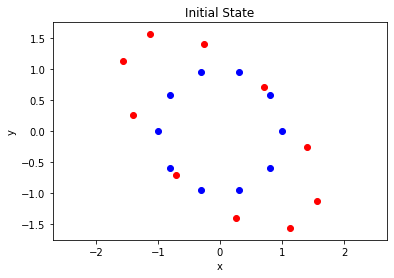

Rigid CPD:
Finished after 50 iterations.
Rigid alignment: [1 2 3 4 5 6 7 8 9 0]

Affine CPD:
Finished after 14 iterations.
Affine alignment: [1 2 3 4 5 6 7 8 9 0]

Non-rigid CPD:
Finished after 9 iterations.
Non-rigid alignment: [1 2 3 4 5 6 7 8 9 0]



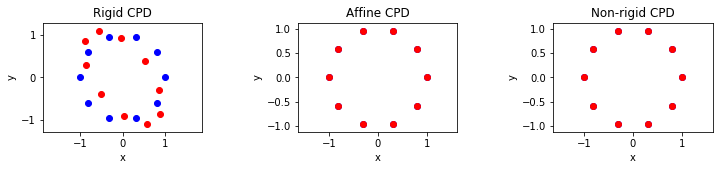

In [3]:
N, M = 10, 10

# Circle
r = 1
angle = (np.arange(N) * 2 * np.pi / N).reshape(-1, 1)
X = r * np.concatenate([np.cos(angle), np.sin(angle)], axis=1)

# Rotation matrix with alpha = pi/4 (= 45°)
alpha = np.pi / 4
R = np.array([[np.cos(alpha), -np.sin(alpha)],
              [np.sin(alpha), np.cos(alpha)]])

# 0 = normal, 1 = rotate ellipse by alpha, 2 = rotate X before creating ellipse
mode = 1

# Ellipse
a, b = 1, 2
if mode < 2:
    Y = np.copy(X)
    Y[:, 1] = (b / a * np.sqrt(a**2 - Y[:, 0]**2)) * (-1)**(X[:, 1] < 0)
    if mode == 1:
        Y = Y @ R.T
elif mode == 2:
    Y = X @ R.T
    Y[:, 1] = (b / a * np.sqrt(a**2 - Y[:, 0]**2)) * (-1)**(X[:, 1] < 0)

# Plot initial state
plt.title('Initial State')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X[:, 0], X[:, 1], c='b')
plt.scatter(Y[:, 0], Y[:, 1], c='r')
plt.axis('equal')
plt.show()

# Rigid CPD
print('Rigid CPD:')
cpd_rigid = CPD(method='rigid')
Y_aligned_rigid, P = cpd_rigid(X, Y, w=0, max_iterations=50)
print(f'Rigid alignment: {np.argmax(P, axis=1)}\n')

# Affine CPD
print('Affine CPD:')
cpd_affine = CPD(method='affine')
Y_aligned_affine, P = cpd_affine(X, Y, w=0, max_iterations=14)
print(f'Affine alignment: {np.argmax(P, axis=1)}\n')

# Non-rigid CPD
print('Non-rigid CPD:')
cpd_nonrigid = CPD(method='nonrigid')
Y_aligned_nonrigid, P = cpd_nonrigid(X, Y, w=0, max_iterations=50)
print(f'Non-rigid alignment: {np.argmax(P, axis=1)}\n')

# Plot result
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
for i in range(3):
    axs[i].scatter(X[:, 0], X[:, 1], c='b')
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
axs[0].set_title('Rigid CPD')
axs[0].scatter(Y_aligned_rigid[:, 0], Y_aligned_rigid[:, 1], c='r')
axs[1].set_title('Affine CPD')
axs[1].scatter(Y_aligned_affine[:, 0], Y_aligned_affine[:, 1], c='r')
axs[2].set_title('Non-rigid CPD')
axs[2].scatter(Y_aligned_nonrigid[:, 0], Y_aligned_nonrigid[:, 1], c='r')
plt.subplots_adjust(wspace=0.6)
plt.show()

### Play Animation

In [4]:
if mode == 0:
    print('Affine CPD:')
else:
    print('Non-rigid CPD:')
    
cpd_affine.play_animation(X, Y, w=0) if mode == 0 else cpd_nonrigid.play_animation(X, Y, w=0)

Non-rigid CPD:
Finished after 9 iterations.


### Example 2: Match a rectangle to a square (Many-to-1 matching)

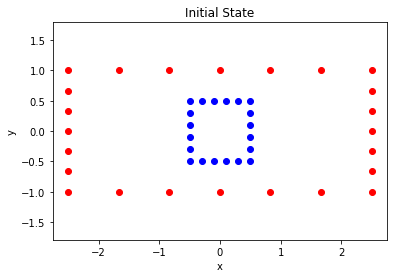

Rigid CPD:
Finished after 50 iterations.
Rigid alignment: [ 0  0  1  2  4 15  5  5  6  7  9 10 10 10 10 12  0  0 15 15 15 17  5  5]

Affine CPD:
Finished after 40 iterations.
Affine alignment: [ 0  1  2  2  3  4  5  6  7  7  8  9 10 11 12 12 13 14 15 16 17 17 18 19]

Non-rigid CPD:
Finished after 16 iterations.
Non-rigid alignment: [ 0  1  2  3  3  4  5  6  7  7  8  9 10 11 12 12 13 14 15 16 17 18 18 19]



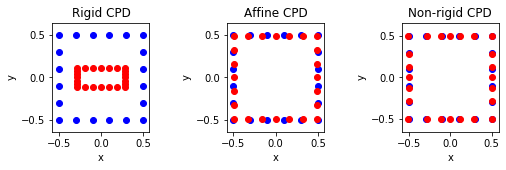

In [5]:
N, M = 20, 24

# x_coord, y_coord: N / 4 points at top, bottom, left, right

# Square
a = 1
x_coord1 = np.concatenate([np.arange(-a/2, a/2, a/(N//4)), np.arange(a/2, -a/2, -a/(N//4)), -a/2 * np.ones(N//4), a/2 * np.ones(N//4)], axis=0).reshape(-1, 1)
y_coord1 = np.concatenate([a/2 * np.ones(N//4), -a/2 * np.ones(N//4), np.arange(-a/2, a/2, a/(N//4)), np.arange(a/2, -a/2, -a/(N//4))], axis=0).reshape(-1, 1)
X = np.concatenate([x_coord1, y_coord1], axis=1)

# Rectangle
w, h = 5, 2
x_coord2 = np.concatenate([np.arange(-w/2, w/2, w/(M//4)), np.arange(w/2, -w/2, -w/(M//4)), -w/2 * np.ones(M//4), w/2 * np.ones(M//4)], axis=0).reshape(-1, 1)
y_coord2 = np.concatenate([h/2 * np.ones(M//4), -h/2 * np.ones(M//4), np.arange(-h/2, h/2, h/(M//4)), np.arange(h/2, -h/2, -h/(M//4))], axis=0).reshape(-1, 1)
Y = np.concatenate([x_coord2, y_coord2], axis=1)

# Plot initial state
plt.title('Initial State')
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(X[:, 0], X[:, 1], c='b')
plt.scatter(Y[:, 0], Y[:, 1], c='r')
plt.axis('equal')
plt.show()

# Rigid CPD
print('Rigid CPD:')
cpd_rigid = CPD(method='rigid')
Y_aligned_rigid, P = cpd_rigid(X, Y, w=0, max_iterations=50)
print(f'Rigid alignment: {np.argmax(P, axis=1)}\n')

# Affine CPD
print('Affine CPD:')
cpd_affine = CPD(method='affine')
Y_aligned_affine, P = cpd_affine(X, Y, w=0, max_iterations=50)
print(f'Affine alignment: {np.argmax(P, axis=1)}\n')

# Non-rigid CPD
print('Non-rigid CPD:')
cpd_nonrigid = CPD(method='nonrigid')
Y_aligned_nonrigid, P = cpd_nonrigid(X, Y, w=0, max_iterations=50)
print(f'Non-rigid alignment: {np.argmax(P, axis=1)}\n')

# Plot result
fig, axs = plt.subplots(1, 3, figsize=(8, 2))
for i in range(3):
    axs[i].scatter(X[:, 0], X[:, 1], c='b')
    axs[i].axis('equal')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y')
axs[0].set_title('Rigid CPD')
axs[0].scatter(Y_aligned_rigid[:, 0], Y_aligned_rigid[:, 1], c='r')
axs[1].set_title('Affine CPD')
axs[1].scatter(Y_aligned_affine[:, 0], Y_aligned_affine[:, 1], c='r')
axs[2].set_title('Non-rigid CPD')
axs[2].scatter(Y_aligned_nonrigid[:, 0], Y_aligned_nonrigid[:, 1], c='r')
plt.subplots_adjust(wspace=0.8)
plt.show()

### Play Animation

In [6]:
print('Non-rigid CPD:')
cpd_nonrigid.play_animation(X, Y, w=0)

Non-rigid CPD:
Finished after 16 iterations.
